In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [2]:
#get directories and open separated datasets


time_interval = 10 #sec/frame

datadir = 'E:/Aaron/Combined_37C_Confocal_PCA_nospeedoutliers/'
savedir = datadir + 'CK666/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)


nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)


#limit data to the CK666 experiments
TotalFrame = FullFrame[FullFrame.Experiment == 'Drug']
dates = [20240610,20240617,20240620]
TotalFrame = TotalFrame[TotalFrame.Date.isin(dates)]
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['DMSO','CK666'], ordered=True)

In [19]:
################# get "n" of the dataset ###########
inn = len(TotalFrame[TotalFrame.Treatment =='DMSO'])
cn = len(TotalFrame[TotalFrame.Treatment =='DMSO'].CellID.unique())
print(f'There are {inn} images of {cn} unique DMSO cells')
inn = len(TotalFrame[TotalFrame.Treatment =='CK666'])
cn = len(TotalFrame[TotalFrame.Treatment =='CK666'].CellID.unique())
print(f'There are {inn} images of {cn} unique CK666 cells')

There are 10553 images of 122 unique DMSO cells
There are 10640 images of 117 unique CK666 cells


In [3]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


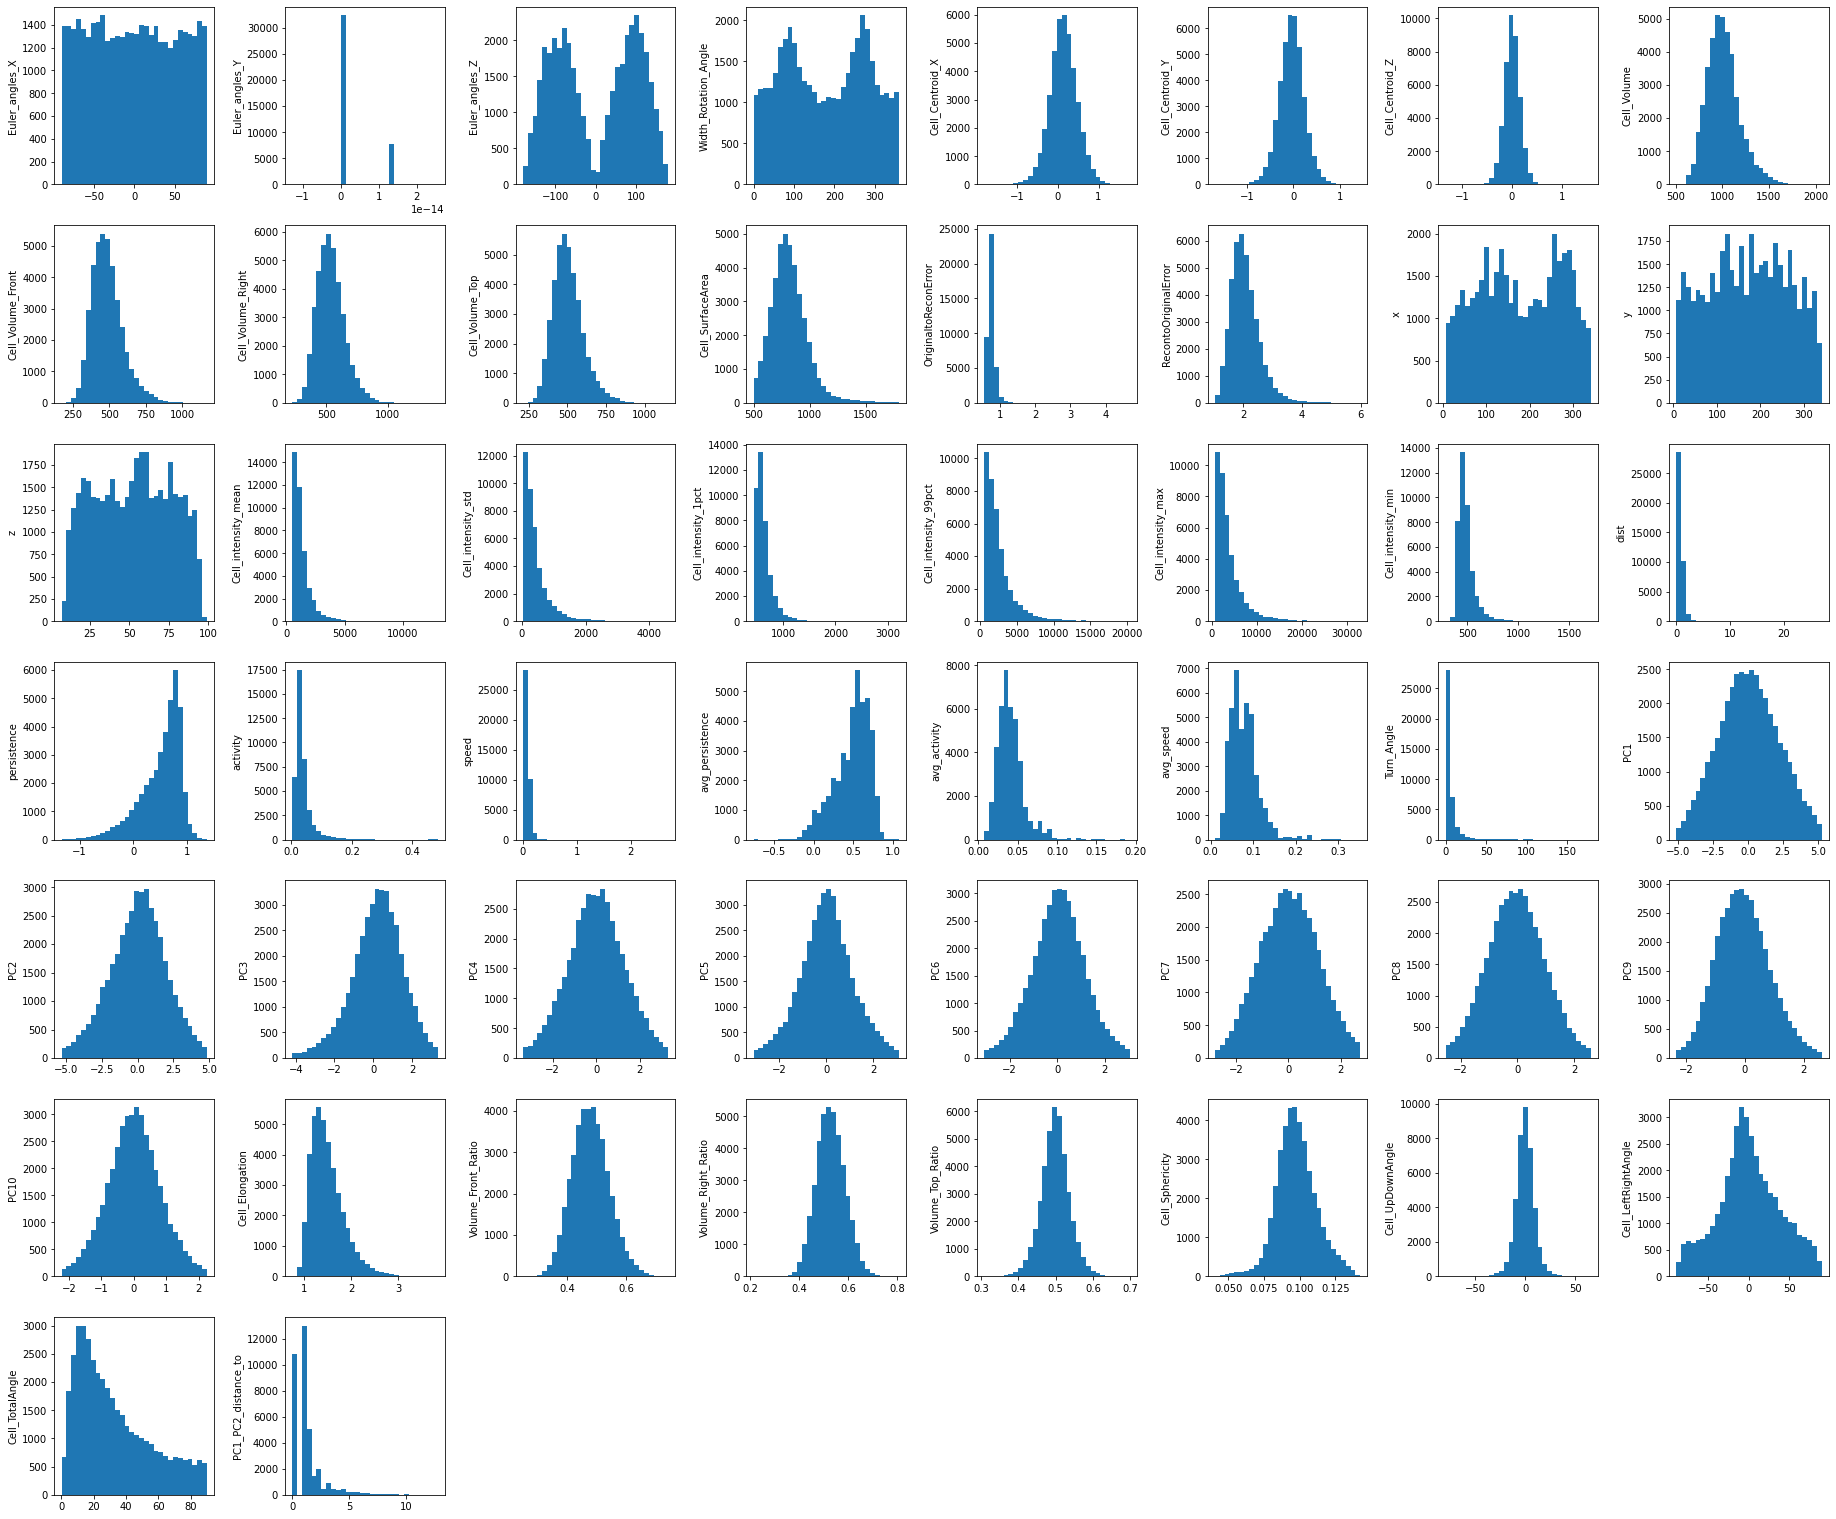

In [7]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell','cell.1','CellID','structure','frame','Treatment'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
# plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

In [53]:
ModeFrame.loc[ModeFrame[c].dropna().index.to_list()].Treatment

19268                       DMSO
40802                       DMSO
40801                       DMSO
40800                       DMSO
40799                       DMSO
                  ...           
46760    Para-Nitro-Blebbistatin
46761    Para-Nitro-Blebbistatin
46762    Para-Nitro-Blebbistatin
46704    Para-Nitro-Blebbistatin
59534    Para-Nitro-Blebbistatin
Name: Treatment, Length: 36322, dtype: category
Categories (3, object): ['DMSO' < 'CK666' < 'Para-Nitro-Blebbistatin']

In [4]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        test_stat, p_val = ss.ttest_ind(samples[0], samples[1])
        print(f'Name: {c}, t-statistic: {test_stat}, p value: {p_val}')
        if p_val < 0.05:
            siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c].dropna(), ModeFrame.loc[ModeFrame[c].dropna().index.to_list()].Treatment))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Name: Cell_Volume, t-statistic: -2.6421337933307356, p value: 0.008244602781548517
Name: Cell_Volume_Front, t-statistic: 1.5895164933124286, p value: 0.11195875126450781
Name: Cell_Volume_Right, t-statistic: -2.8051908610323886, p value: 0.005033259814511841
Name: Cell_Volume_Top, t-statistic: -2.9202280161194794, p value: 0.003501438988229514
Name: Cell_SurfaceArea, t-statistic: -6.454730568115154, p value: 1.1075927725375284e-10
Name: persistence, t-statistic: 13.504500792378613, p value: 2.206788251489488e-41
Name: speed, t-statistic: 20.61302061766622, p value: 1.7837282074303126e-93
Name: directional_autocorrelation, t-statistic: 10.949955777338642, p value: 7.932377016866759e-28
Name: Turn_Angle, t-statistic: -8.142617967623007, p value: 4.0830150157780585e-16
Name: PC1, t-statistic: -9.519760953566474, p value: 1.9159178564353955e-21
Name: PC2, t-statistic: 0.2974952382248272, p value: 0.766091359076035
Name: PC3, t-statistic: -1.8900336122114063, p value: 0.05876709911550206
Na

In [5]:
#get the number of images of cells and unique cells per migration mode
samplesize = pd.DataFrame([])

for m, mod in TotalFrame.groupby('Treatment'):
    imnum = len(mod)
    cellnum = len(mod.CellID.unique())
    samplesize = samplesize.append(pd.DataFrame({'Treatment':m,
                                                 'Cells':cellnum, 
                                                'Images':imnum}, index = [0]))

samplesize = samplesize.reset_index(drop=True)
samplesize

,Treatment,Cells,Images
0,DMSO,269,20185
1,CK666,79,6812
2,Para-Nitro-Blebbistatin,155,11369


In [19]:
# axli[i].get_xticklabels()[3].set_text('blah')
for n, t in enumerate(axli[i].get_xticklabels()):
    if t.get_text() == 'Para-Nitro-Blebbistatin':
        axli[i].get_xticklabels()[n].set_text('Para-Nitro/n-Blebbistatin')
axli[i].get_xticklabels()

[Text(0, 0, 'blah'),
 Text(1, 0, 'CK666'),
 Text(2, 0, 'Para-Nitro/n-Blebbistatin')]

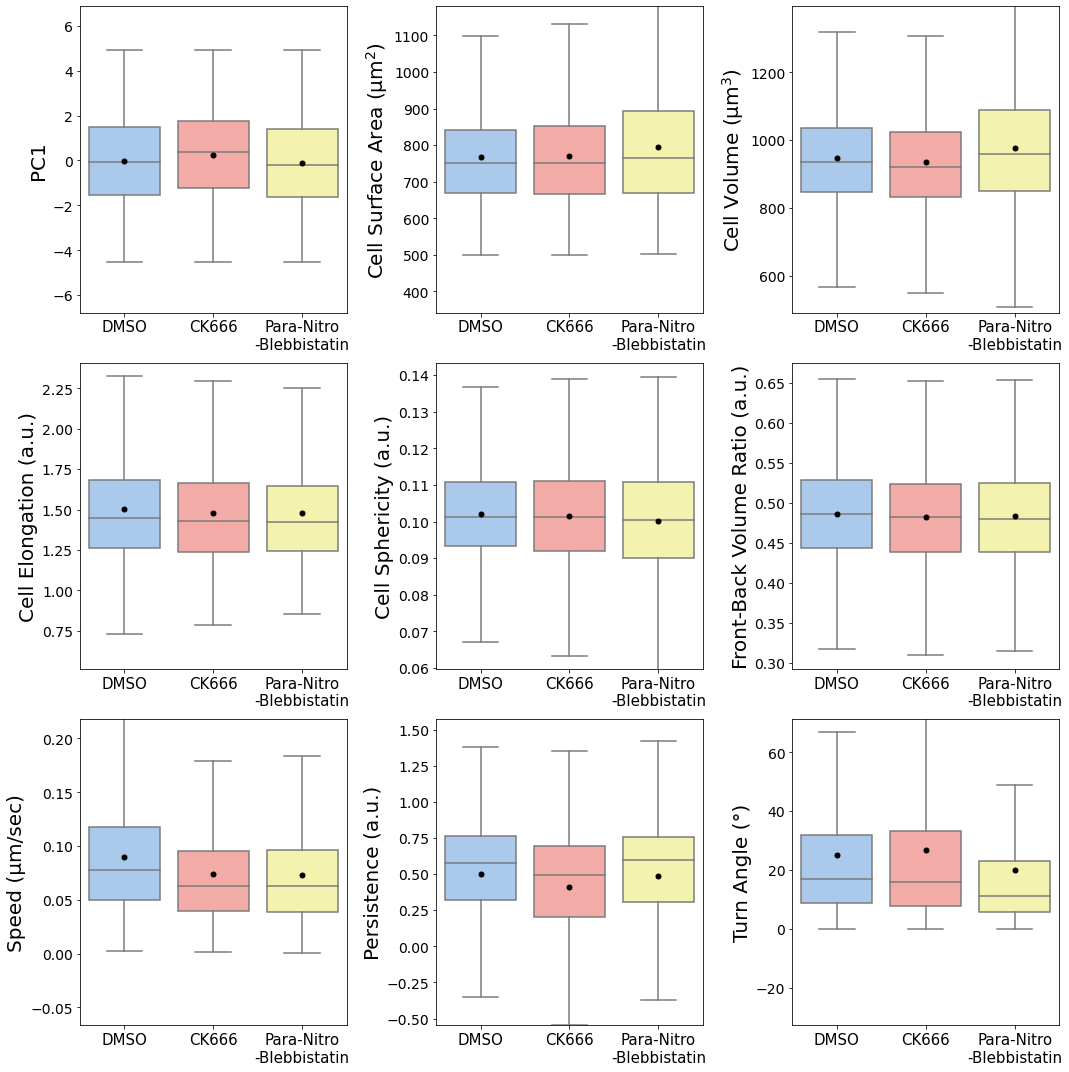

In [15]:
############### Metric distributions by drug #################################
import re


#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['PC1','Cell_SurfaceArea','Cell_Volume','Cell_Elongation', 'Cell_Sphericity',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle']
siglabels = ['PC1','Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 'Cell Sphericity (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)']

sp = math.ceil(math.sqrt(len(smallersig)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, palette = colorlist,# width = 0.15, 
            fliersize=0, showmeans=True, boxprops={'zorder': 2}, 
            meanprops={"marker": ".","markerfacecolor": "black","markeredgecolor": "black","markersize": "10"},ax=axli[i])
    Q1 = TotalFrame[sig].quantile(0.25)
    Q3 = TotalFrame[sig].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    for n, t in enumerate(axli[i].get_xticklabels()):
        if t.get_text() == 'Para-Nitro-Blebbistatin':
            axli[i].get_xticklabels()[n].set_text('Para-Nitro\n-Blebbistatin')
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Drug comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




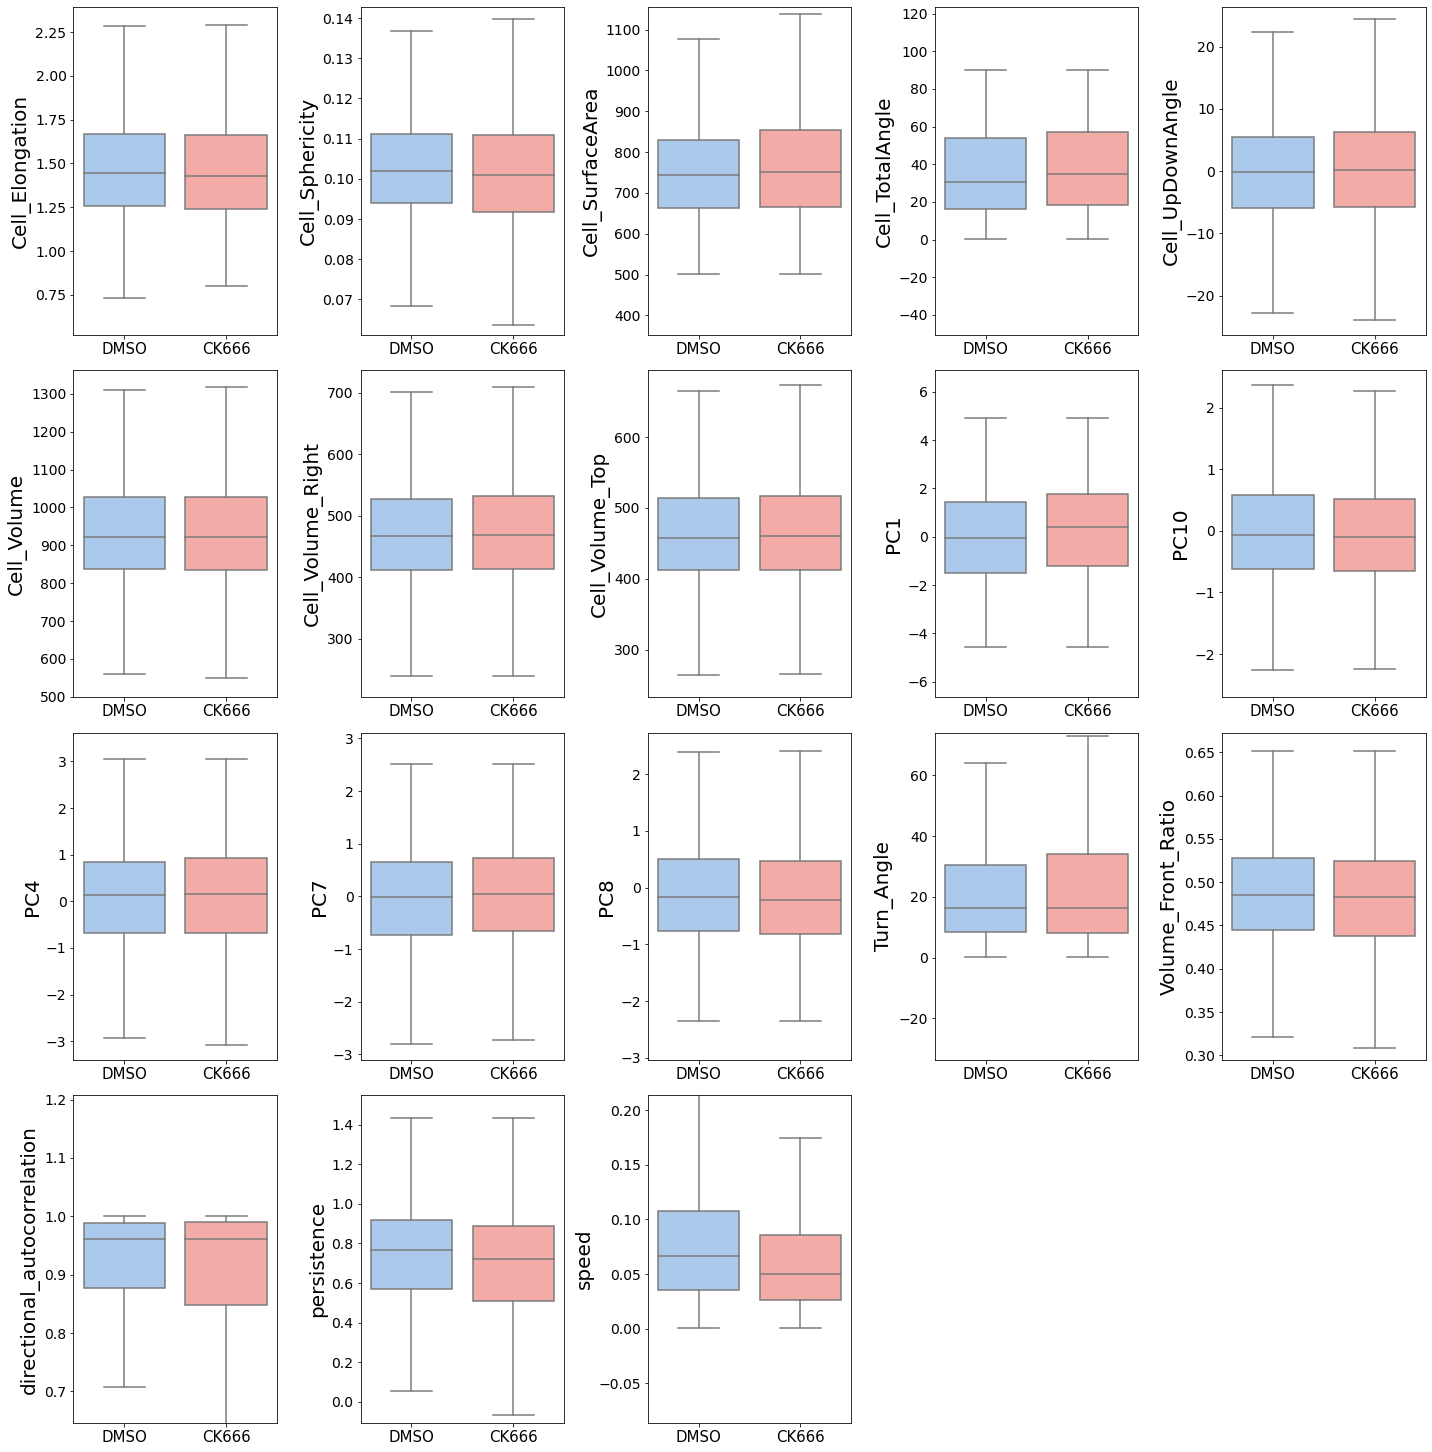

In [21]:
############### Metric distributions by drug #################################
import re


#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation',
              'speed','persistence',
             'Turn_Angle']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 
             'Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)']

sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = TotalFrame[sig].quantile(0.25)
    Q3 = TotalFrame[sig].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel(sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Drug comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




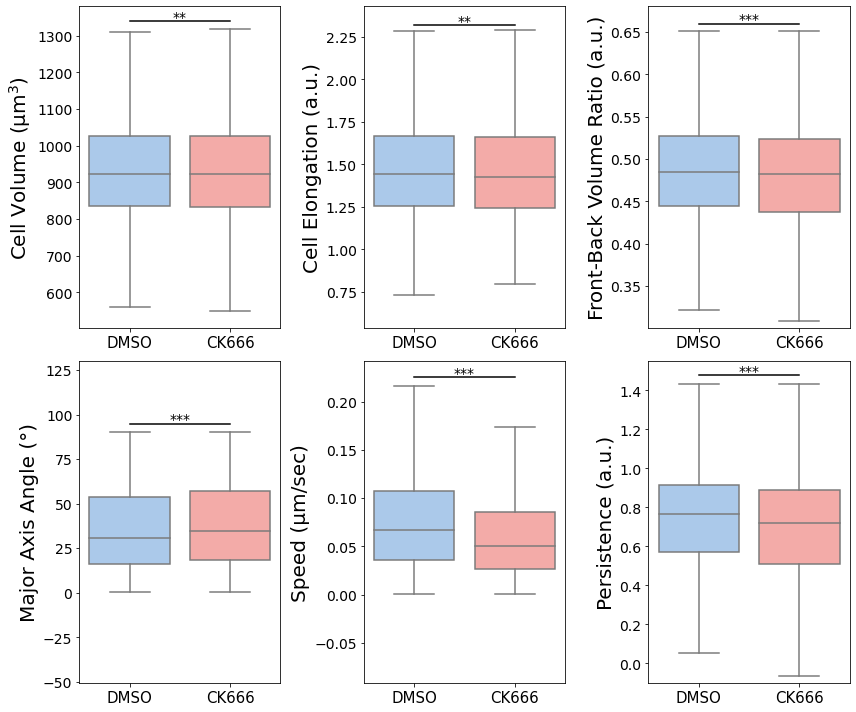

In [15]:
############### Metric distributions by drug #################################
import re


#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_Volume','Cell_Elongation','Volume_Front_Ratio','Cell_TotalAngle',
              'speed','persistence']
siglabels = ['Cell Volume (µm$^3$)', 'Cell Elongation (a.u.)', 'Front-Back Volume Ratio (a.u.)', 'Major Axis Angle (°)',
             'Speed (µm/sec)','Persistence (a.u.)']

sp = math.ceil(math.sqrt(len(smallersig)))
fig, axes = plt.subplots(2, 3, figsize=(12,10))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, palette = colorlist,# width = 0.15, 
            showfliers=False, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = max(TotalFrame.loc[TotalFrame.Treatment == 'DMSO',sig].quantile(0.25),
             TotalFrame.loc[TotalFrame.Treatment == 'CK666', sig].quantile(0.25))
    Q3 = max(TotalFrame.loc[TotalFrame.Treatment == 'DMSO', sig].quantile(0.75),
             TotalFrame.loc[TotalFrame.Treatment == 'CK666', sig].quantile(0.75))
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.85*IQR)
    if sig == 'persistence':
        axli[i].set_ylim(-.1, 1.55)
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
axli[0].axhline(1340,xmin=0.25, xmax = 0.75,color = 'black')
axli[0].text(0.5,1340,'**',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[1].axhline(2.32,xmin=0.25, xmax = 0.75,color = 'black')
axli[1].text(0.5,2.32,'**',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[2].axhline(.66,xmin=0.25, xmax = 0.75,color = 'black')
axli[2].text(0.5,.66,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[3].axhline(95,xmin=0.25, xmax = 0.75,color = 'black')
axli[3].text(0.5,95,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[4].axhline(0.225,xmin=0.25, xmax = 0.75,color = 'black')
axli[4].text(0.5,0.225,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[5].axhline(1.48,xmin=0.25, xmax = 0.75,color = 'black')
axli[5].text(0.5,1.48,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
    
    
plt.tight_layout()
plt.savefig(savedir + 'Drug comparison significant metric boxes nice.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


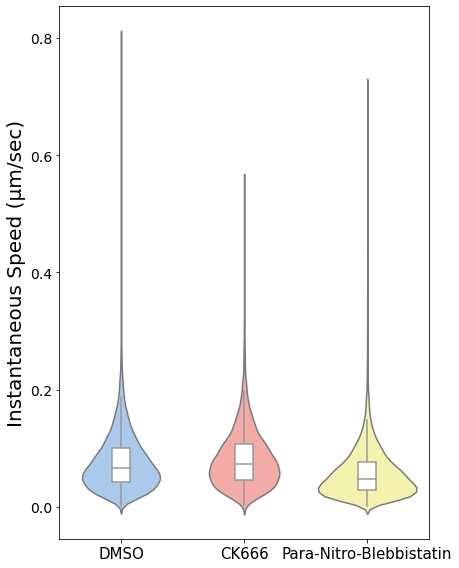

In [7]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular Bias'] = angles

#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = tempframe[tempframe.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['speed']
siglabels = ['Instantaneous Speed (µm/sec)']


fig, ax = plt.subplots(1, 1, figsize=(6.5,8))#, sharex=True)

vp = sns.violinplot(data=tempframe, x='Treatment', y='speed', palette = colorlist, inner = None, ax=ax, )
bp = sns.boxplot(data=tempframe, x='Treatment', y='speed', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=ax)
ax.set_ylabel(siglabels[0], fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels(tempframe.Treatment.unique(), fontsize = 15)#, rotation=45)#, ha = 'right')


plt.tight_layout()
plt.savefig(savedir + 'speed metric violins.png', bbox_inches='tight')




C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


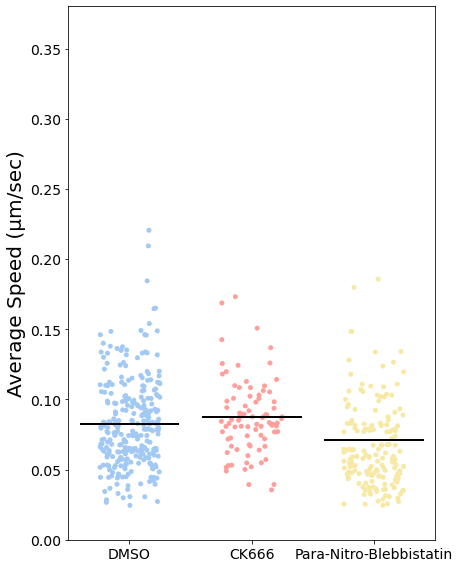

In [8]:
tempframe = TotalFrame[TotalFrame.speed<0.8]
realavg = []
for i, c in tempframe.groupby(['CellID', 'Treatment']):
    realavg.append([i[0], i[1], c.speed.mean()])
newrealavg = pd.DataFrame(realavg, columns = ['CellID','Treatment','Average Speed (µm/sec)'])


colorlist = ['#a1c9f4', '#ff9f9b', '#f7e9a3']

fig, ax = plt.subplots(figsize = (6.5,8))
sns.stripplot(newrealavg['Treatment'],newrealavg['Average Speed (µm/sec)'], jitter = 0.25, palette = colorlist, ax = ax)

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=newrealavg['Treatment'],
            y=newrealavg['Average Speed (µm/sec)'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(),fontsize=20)
ax.set_ylim(0,0.38)
ax.tick_params('x', labelsize=14)
ax.tick_params('y', labelsize=14)


plt.tight_layout()
plt.savefig(savedir + 'average speed metric jitter.png', bbox_inches='tight')

In [129]:
for i,x in TotalFrame.groupby('Treatment'):
    print(i, x.Cell_Elongation.mean())

DMSO 1.4823196268539875
CK666 1.5066161690532378
Para-Nitro-Blebbistatin 1.537569831290352


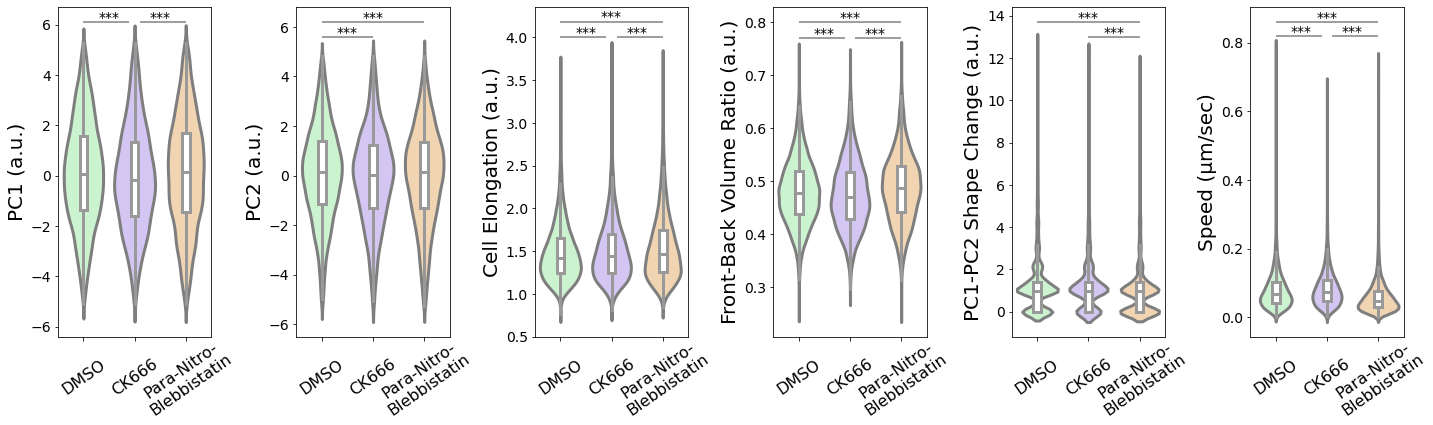

In [138]:
############### Metric distributions by treatment FOR ASCB #################################

import re


#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = tempframe[tempframe.Turn_Angle<30]
# tempframe = tempframe[tempframe.PC1_PC2_distance_to<3]


colorlist = ['#c5fac9','#d0befa','#fcd6a7']

smallersig = ['PC1','PC2','Cell_Elongation','Volume_Front_Ratio','PC1_PC2_distance_to','speed']
siglabels = ['PC1 (a.u.)','PC2 (a.u.)','Cell Elongation (a.u.)','Front-Back Volume Ratio (a.u.)','PC1-PC2 Shape Change (a.u.)','Speed (µm/sec)']



fig, axes = plt.subplots(1, 6, figsize=(20,6))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Migration_Mode'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, palette = colorlist, linewidth=3, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Treatment', y=sig, width = 0.15, 
            color = 'white', showcaps=False, linewidth=3, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(['DMSO','CK666','Para-Nitro-\nBlebbistatin'], fontdict= {'fontsize': 16,
                                                                                      'verticalalignment':'center',
                                                                                      'rotation':35,
                                                                                      'y':-.1})

# ax.tick_params('x', labelsize=16, rotation = 35)

axli[0].hlines(6.1, 0, .9, colors='grey', linestyles='solid')
axli[0].text(0.5,6.11,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[0].hlines(6.1, 1.1, 2, colors='grey', linestyles='solid')
axli[0].text(1.5,6.11,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
    
axli[1].hlines(5.6, 0, 1, colors='grey', linestyles='solid')
axli[1].text(0.5,5.61,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[1].hlines(6.2, 0, 2, colors='grey', linestyles='solid')
axli[1].text(1,6.21,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

axli[2].hlines(4, 1.1, 2, colors='grey', linestyles='solid')
axli[2].text(1.5,4.01,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[2].hlines(4.18, 0, 2, colors='grey', linestyles='solid')
axli[2].text(1,4.19,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[2].hlines(4, 0, 0.9, colors='grey', linestyles='solid')
axli[2].text(0.5,4.01,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

axli[3].hlines(.77, 1.1, 2, colors='grey', linestyles='solid')
axli[3].text(1.5,.771,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[3].hlines(.8, 0, 2, colors='grey', linestyles='solid')
axli[3].text(1,.801,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[3].hlines(.77, 0, 0.9, colors='grey', linestyles='solid')
axli[3].text(0.5,.771,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

axli[4].hlines(13, 1, 2, colors='grey', linestyles='solid')
axli[4].text(1.5,13.01,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[4].hlines(13.7, 0, 2, colors='grey', linestyles='solid')
axli[4].text(1,13.71,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

axli[5].hlines(.82, 1.1, 2, colors='grey', linestyles='solid')
axli[5].text(1.5,.821,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[5].hlines(.86, 0, 2, colors='grey', linestyles='solid')
axli[5].text(1,.861,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[5].hlines(.82, 0, 0.9, colors='grey', linestyles='solid')
axli[5].text(0.5,.821,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
    
    
plt.tight_layout()
plt.savefig(savedir + f'treatment metric violins FOR ASCB 2023.png', bbox_inches='tight', dpi = 500)



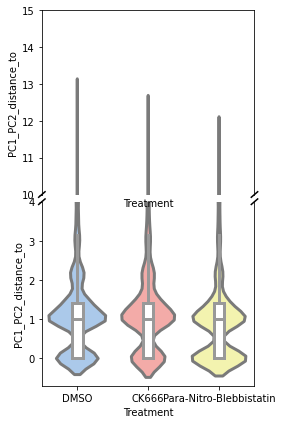

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(4,6))#, sharex=True)

# for m, mig in tempframe.groupby('Migration_Mode'):
divider = make_axes_locatable(ax)
ax2 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax2)

vp = sns.violinplot(data=tempframe, x='Treatment', y='PC1_PC2_distance_to', palette = colorlist, linewidth=3, inner = None, ax=ax, )
bp = sns.boxplot(data=tempframe, x='Treatment', y='PC1_PC2_distance_to', width = 0.15, 
        color = 'white', showcaps=False, linewidth=3, fliersize=0, boxprops={'zorder': 2}, ax=ax)
ax.set_ylim(-.7, 4)
ax.spines['top'].set_visible(False)
vp = sns.violinplot(data=tempframe, x='Treatment', y='PC1_PC2_distance_to', palette = colorlist, linewidth=3, inner = None, ax=ax2, )
bp = sns.boxplot(data=tempframe, x='Treatment', y='PC1_PC2_distance_to', width = 0.15, 
        color = 'white', showcaps=False, linewidth=3, fliersize=0, boxprops={'zorder': 2}, ax=ax2)
ax2.set_ylim(10, 15)
ax2.tick_params(bottom=False, labelbottom=False)
ax2.spines['bottom'].set_visible(False)


# From https://matplotlib.org/examples/pylab_examples/broken_axis.html
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.tight_layout()

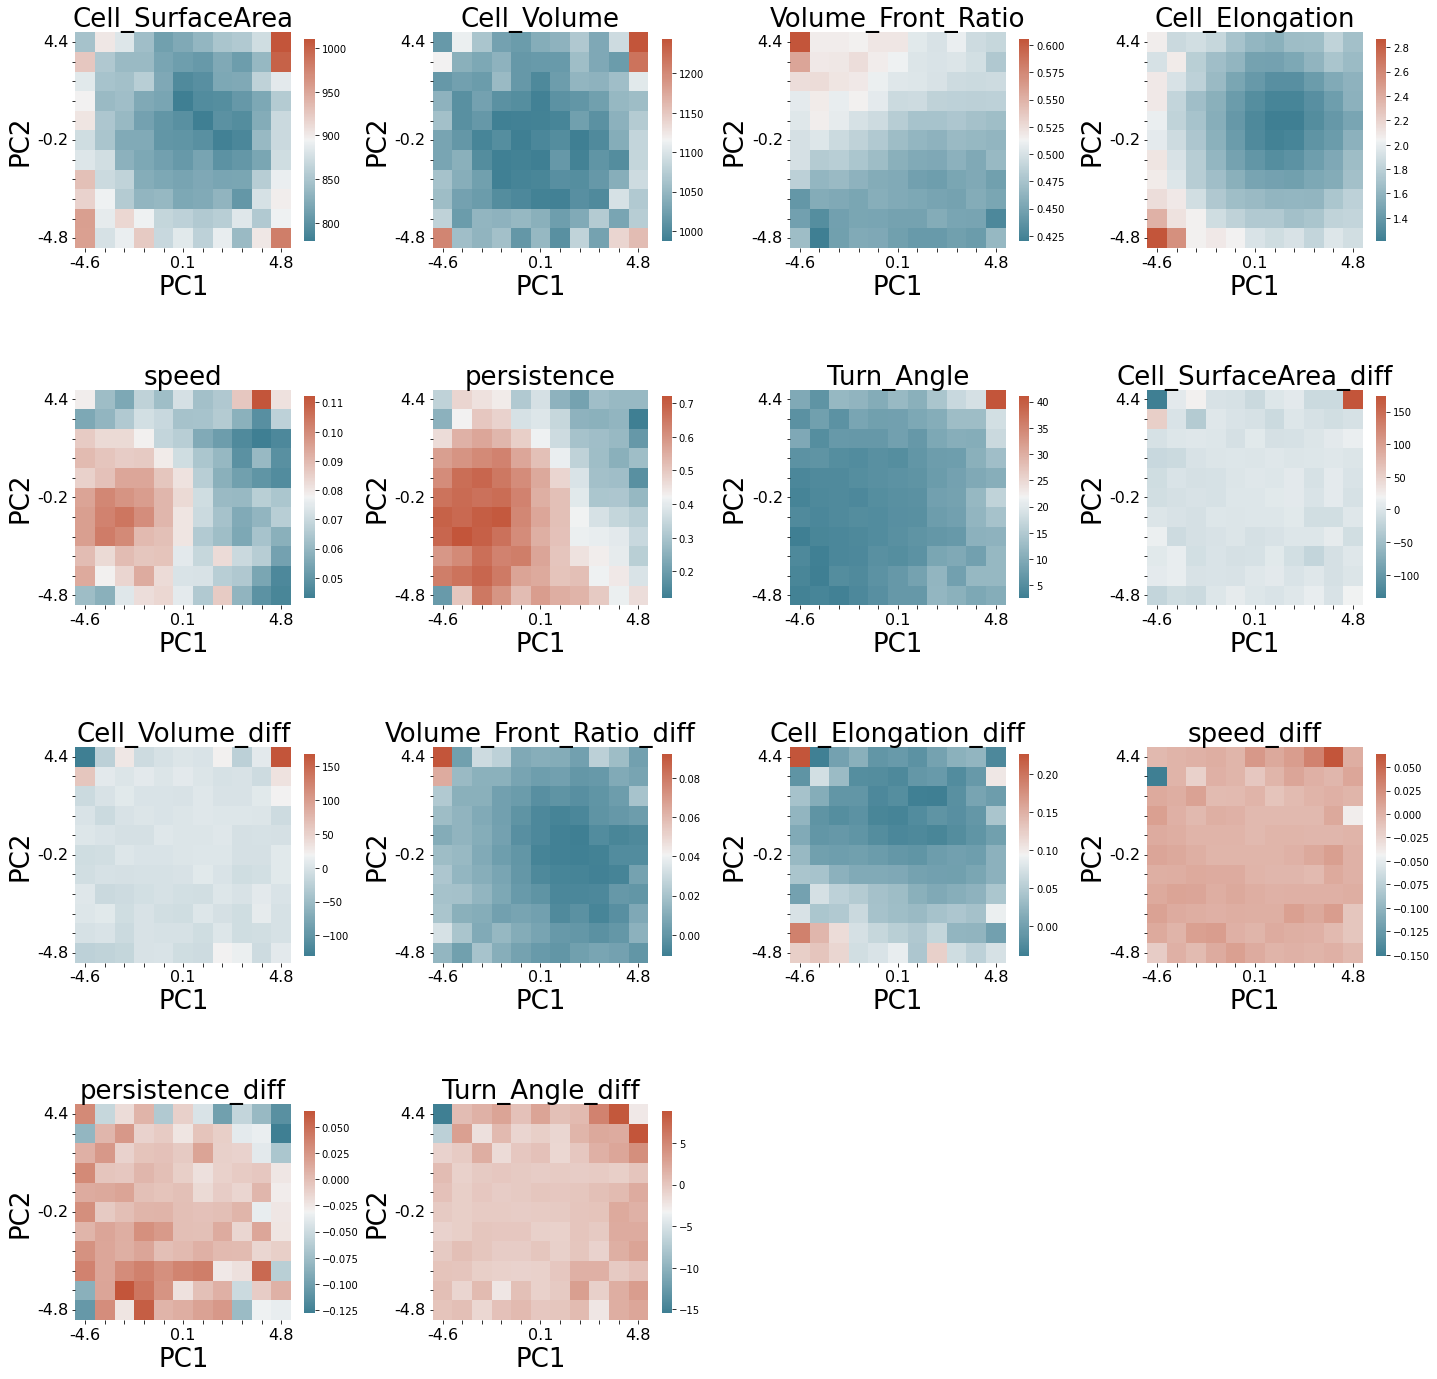

In [6]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

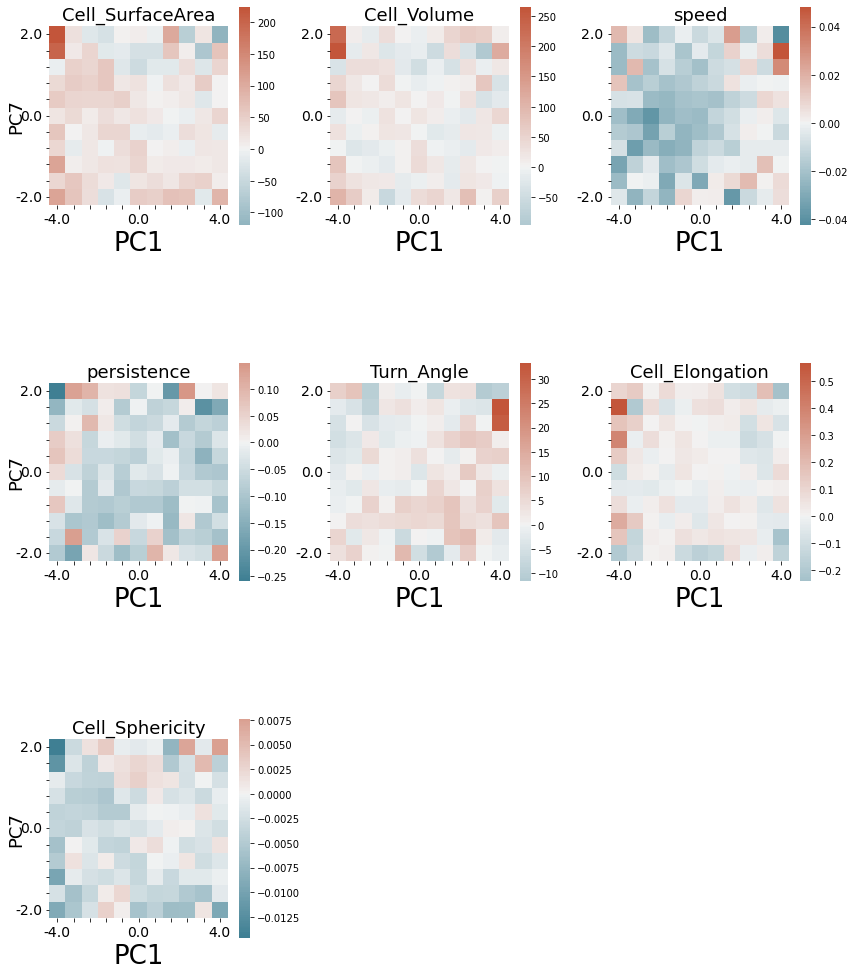

In [7]:
########### PLOT THE DIFFERENCE DISTRIBUTIONS OF SHAPE METRICS #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle','Cell_Elongation', 'Cell_Sphericity']

sp = math.ceil(math.sqrt(len(metrics)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axf = axes.flatten()
for i, met in enumerate(metrics):
    ax = axf[i]
    ################ heatmap of the given metric #############
    #make numpy array with heatmap data
    bighm = np.zeros((len(TotalFrame.Treatment.unique()),nbins,nbins))
    for n in range(bighm.shape[0]):
        mdf = TotalFrame[TotalFrame.Treatment==TotalFrame.Treatment.unique()[n]]
        for x in range(nbins):
            for y in range(nbins):
                current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC7bins'] == y+1)].dropna(subset=[met])
                if current.empty:
                    bighm[n,y,x] = 0
                elif len(current)==1:
                    bighm[n,y,x] = current[met]
                else:
                    bighm[n,y,x] = current[met].mean()

    diffhm = bighm[1,:,:]-bighm[0,:,:]
    #plot heatmap with seaborn
    #### use the max and the lowest non zero as min
    sns.heatmap(
        diffhm,
        #vmin=np.min(bighm[np.nonzero(bighm)]),
        #vmax=np.max(bighm),
        center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar_kws={'shrink': 0.65}
    )
    ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 14
        )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC7.to_list()],
        rotation=0,
        fontsize = 14
    )
    #take out all axis labels except the desired ones
    for o, l in enumerate(ax.xaxis.get_ticklabels()):
        if o%5 != 0:
            l.set_visible(False)
    for o, l in enumerate(ax.yaxis.get_ticklabels()):
        if o%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)      
    if (i%sp ==0):
        ax.set_ylabel('PC7', fontsize = 18, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(met, fontsize = 18)
for a in range(i+1, len(axf)):
    axf[a].remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC7 difference heatmaps.png', bbox_inches='tight')

C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


Name Cell_Centroid_X          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj  lower    upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  13.8299   0.0  12.5991 15.0607   True
Chem_Directed_Chem Random_Chem   2.3165   0.0   1.1808  3.4522   True
Chem_Directed_Chem Random_Galv   6.5544   0.0   5.2757  7.8331   True
         Galv_Galv Random_Chem -11.5134   0.0 -12.6137 -10.413   True
         Galv_Galv Random_Galv  -7.2755   0.0  -8.5229 -6.0281   True
       Random_Chem Random_Galv   4.2379   0.0   3.0842  5.3916   True
---------------------------------------------------------------------
Name Cell_Centroid_Y          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   4.8776    0.0  

Name Cell_intensity_99pct          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -6.9099    0.0 -10.4941 -3.3257   True
Chem_Directed_Chem Random_Chem   9.9033    0.0    6.596 13.2106   True
Chem_Directed_Chem Random_Galv  -2.6488 0.2602  -6.3725  1.0749  False
         Galv_Galv Random_Chem  16.8132    0.0  13.6089 20.0175   True
         Galv_Galv Random_Galv   4.2611 0.0138   0.6286  7.8937   True
       Random_Chem Random_Galv -12.5521    0.0 -15.9117 -9.1924   True
----------------------------------------------------------------------
Name Cell_intensity_max          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_G

Name PC8          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   1.4552    0.0  1.2838  1.6265   True
Chem_Directed_Chem Random_Chem   0.3745    0.0  0.2164  0.5326   True
Chem_Directed_Chem Random_Galv   1.2123    0.0  1.0343  1.3903   True
         Galv_Galv Random_Chem  -1.0807    0.0 -1.2339 -0.9275   True
         Galv_Galv Random_Galv  -0.2429 0.0019 -0.4165 -0.0692   True
       Random_Chem Random_Galv   0.8378    0.0  0.6772  0.9984   True
---------------------------------------------------------------------
Name PC9          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   0.1491 0.0833 -0.0127  0.3108  False
Ch

Name nucleus_Structure_intensity_1pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Chem      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Galv      nan   nan   nan   nan  False
         Galv_Galv Random_Chem      nan   nan   nan   nan  False
         Galv_Galv Random_Galv      nan   nan   nan   nan  False
       Random_Chem Random_Galv      nan   nan   nan   nan  False
----------------------------------------------------------------
Name nucleus_Structure_intensity_99pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed

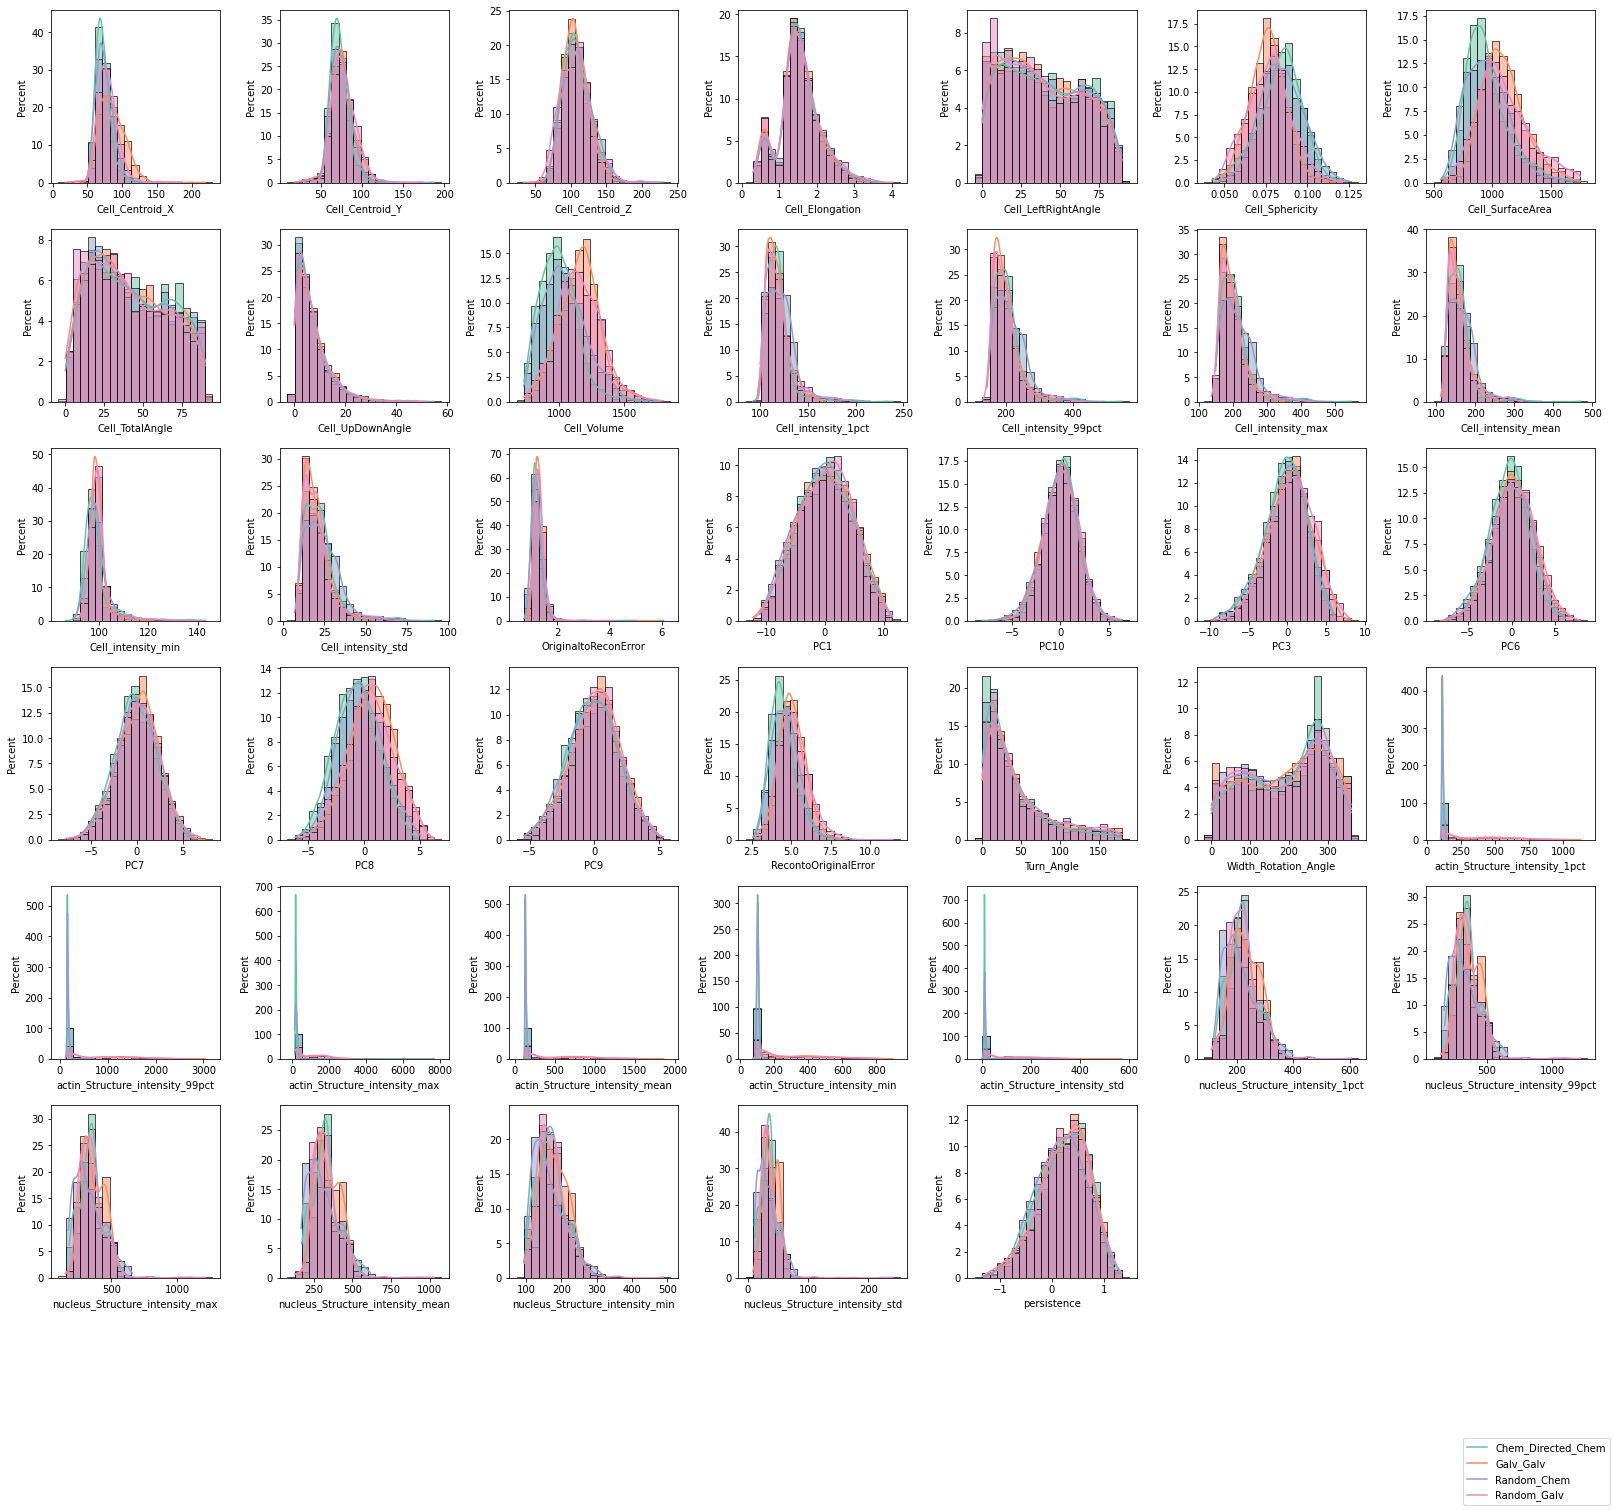

In [68]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])

for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[c]]
    f_val, p_val = ss.f_oneway(*samples)
#     print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c], 
                                         [one+'_'+two for one, two in zip(ModeFrame['Migration_Mode'].to_list(), ModeFrame['Experiment'].to_list())]))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']


################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())

CoRo = math.ceil(math.sqrt(len(siglist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(siglist):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
    sns.histplot(ax = ax, data=samples[3], bins=binss, stat='percent', color = colors[3], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(['_'.join(g) for g, i in ModeFrame.groupby(['Migration_Mode','Experiment'])], loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
# plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

In [3]:
from CustomFunctions import linear_cycle_utils

origin = [5, 6]
whichpcs = [1,7]
binrange = 10
direction = 'counterclockwise'

angframe = linear_cycle_utils.linearize_cycle_continuous(
            TotalFrame, 
            centers,
            origin, 
            whichpcs,  
            binrange, 
            direction,)


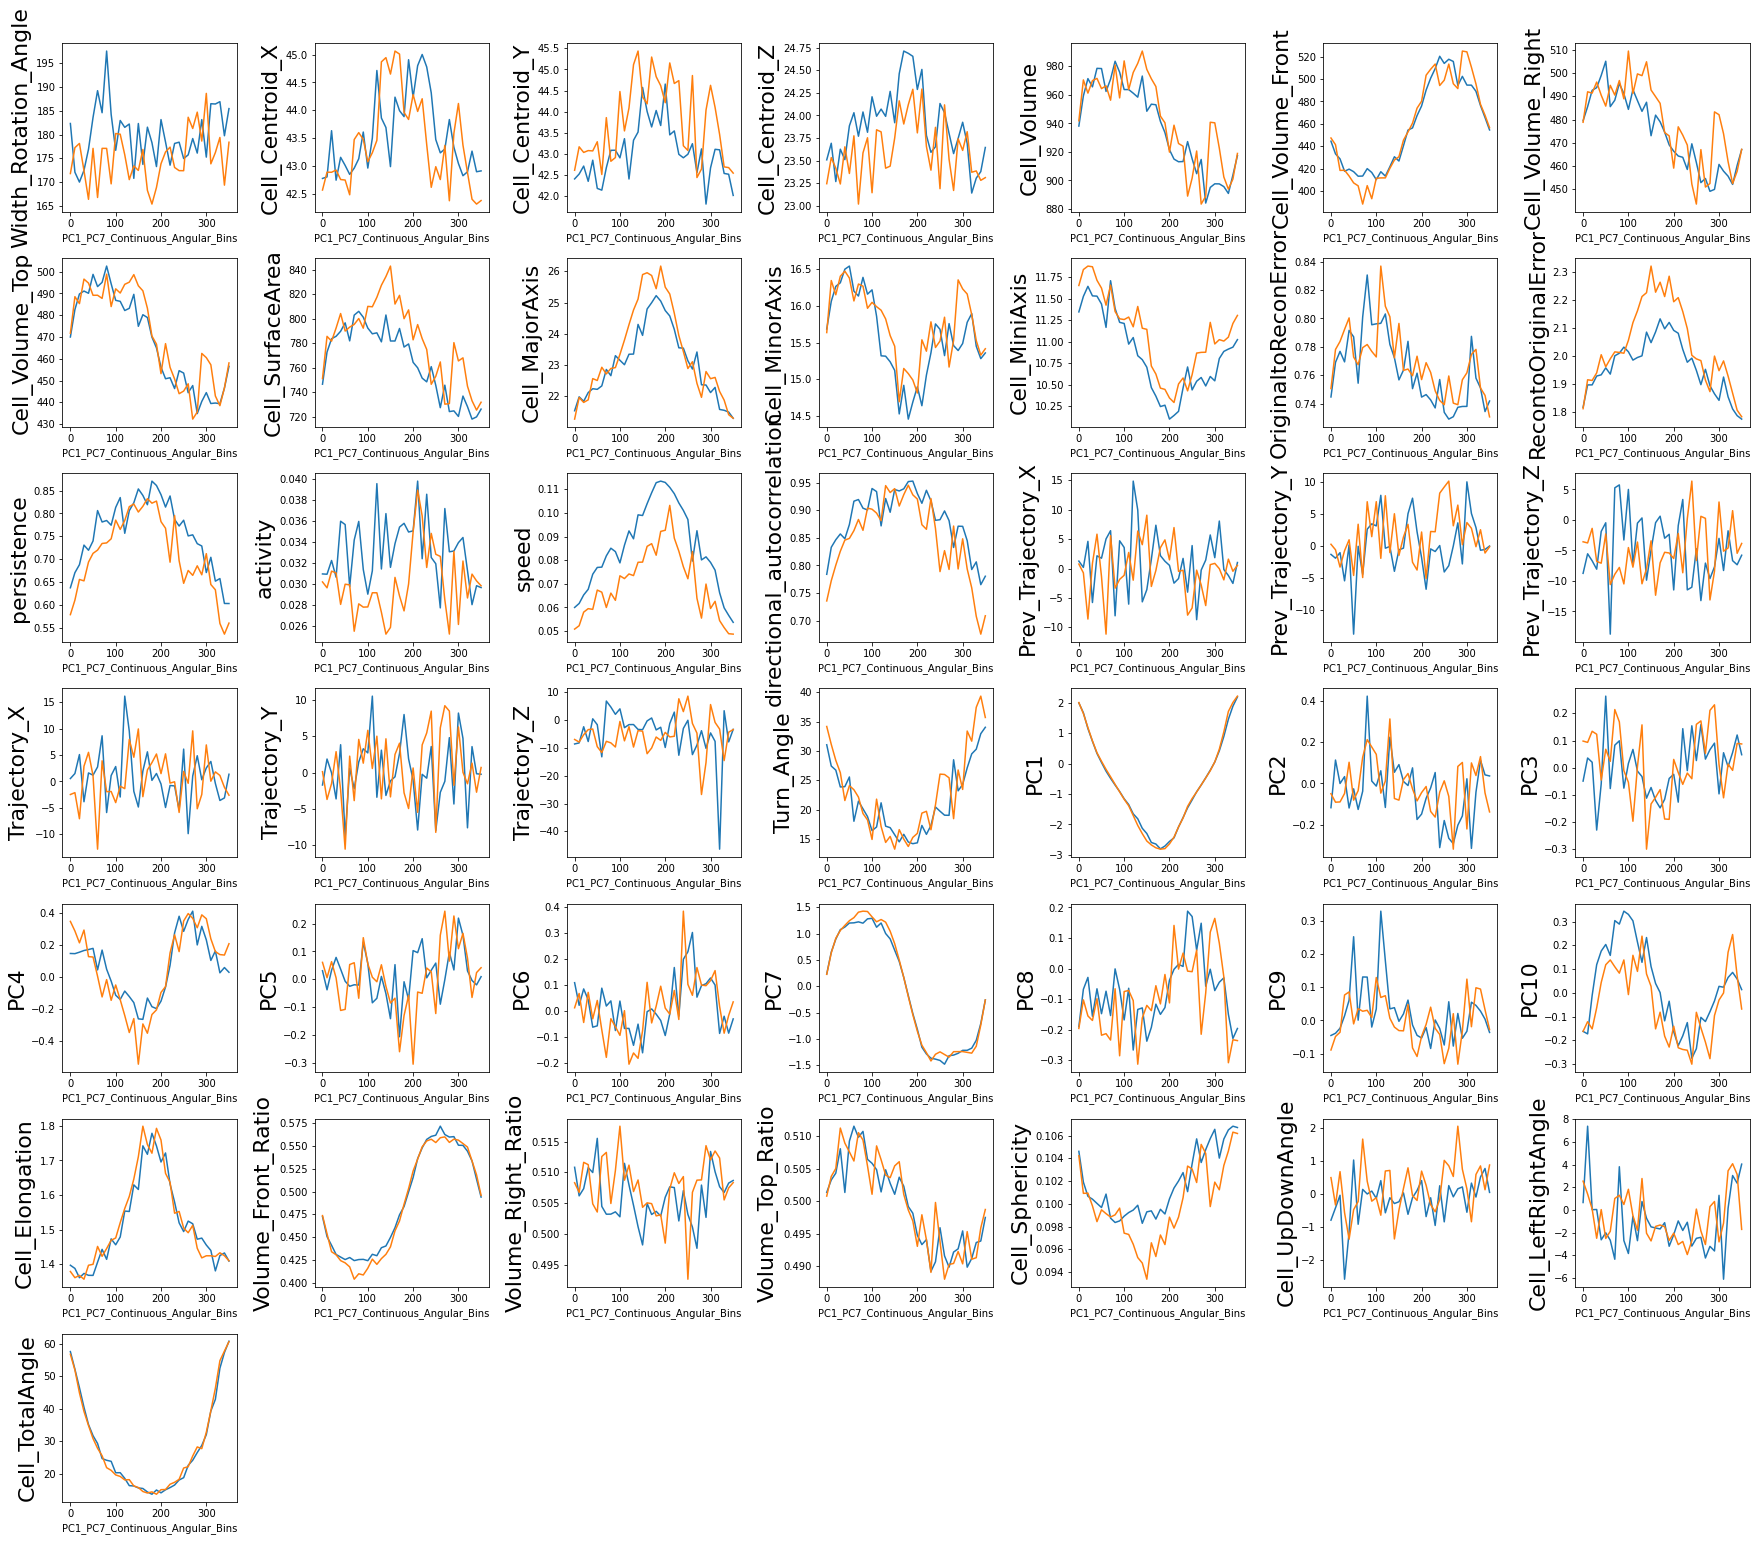

In [4]:
################# LOOK STATS AROUND 1D CYCLE ######################
removeex = []
removeex.extend([x for x in angframe.columns if 'Euler' in x])
removeex.extend([x for x in angframe.columns if 'avg' in x])
removeex.extend([x for x in angframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in angframe.columns if 'intensity' in x])
removeex.extend([x for x in angframe.columns if 'Velocity' in x])
removeex.extend([x for x in angframe.columns if 'Coord' in x])
removeex.extend([x for x in angframe.columns if 'Vec' in x])
removeex.extend([x for x in angframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date'])
newframe = angframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, hue = 'Treatment', ci = None, ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs.png', bbox_inches='tight')

In [4]:
############## bootstrap around the linear cycle for metrics ###################

if os.path.exists(savedir + 'linear CGPS bootstrapped metric.csv'):
    bsframe_sep_full = pd.read_csv(savedir + 'linear CGPS bootstrapped metric.csv', index_col=0)
    print('Opened bootstrap file')
else:    
    
    samplesize = 50
    bsiters = 1000

    ### generate the dataframe with all of the sampled data
    treatlist = []
    celllist = []
    bslist = []
    for t in TotalFrame.Treatment.unique():
        for b in range(bsiters):
            treattemp = TotalFrame[TotalFrame.Treatment == t]
            celllist.extend(random.sample(list(treattemp.CellID.unique()), samplesize))
            treatlist.extend([t]*samplesize)
            bslist.extend([b]*samplesize)

    allbs = pd.DataFrame({'Treatment':treatlist,
                   'bsiter':bslist,
                   'CellID':celllist})


    ### sample linearized dataframe and get averages
    allavgs = []
    for i, bi in allbs.groupby('bsiter'):
        tempangframe = angframe[angframe.CellID.isin(bi.CellID.to_list())]
        for a, ab in tempangframe.groupby(f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'):
            ab['bsiter'] = [i]* len(ab)
            abavg = ab.mean()
            for index, value in zip(['cell','CellID','structure','Treatment','Experiment'],
                                   ab[['cell','CellID','structure','Treatment','Experiment']].iloc[0].values):
                abavg[index] = value
            allavgs.append(abavg)

    allavgsframe = pd.DataFrame(allavgs)
    allavgsframe.to_csv(savedir + 'linear CGPS bootstrapped metric.csv')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


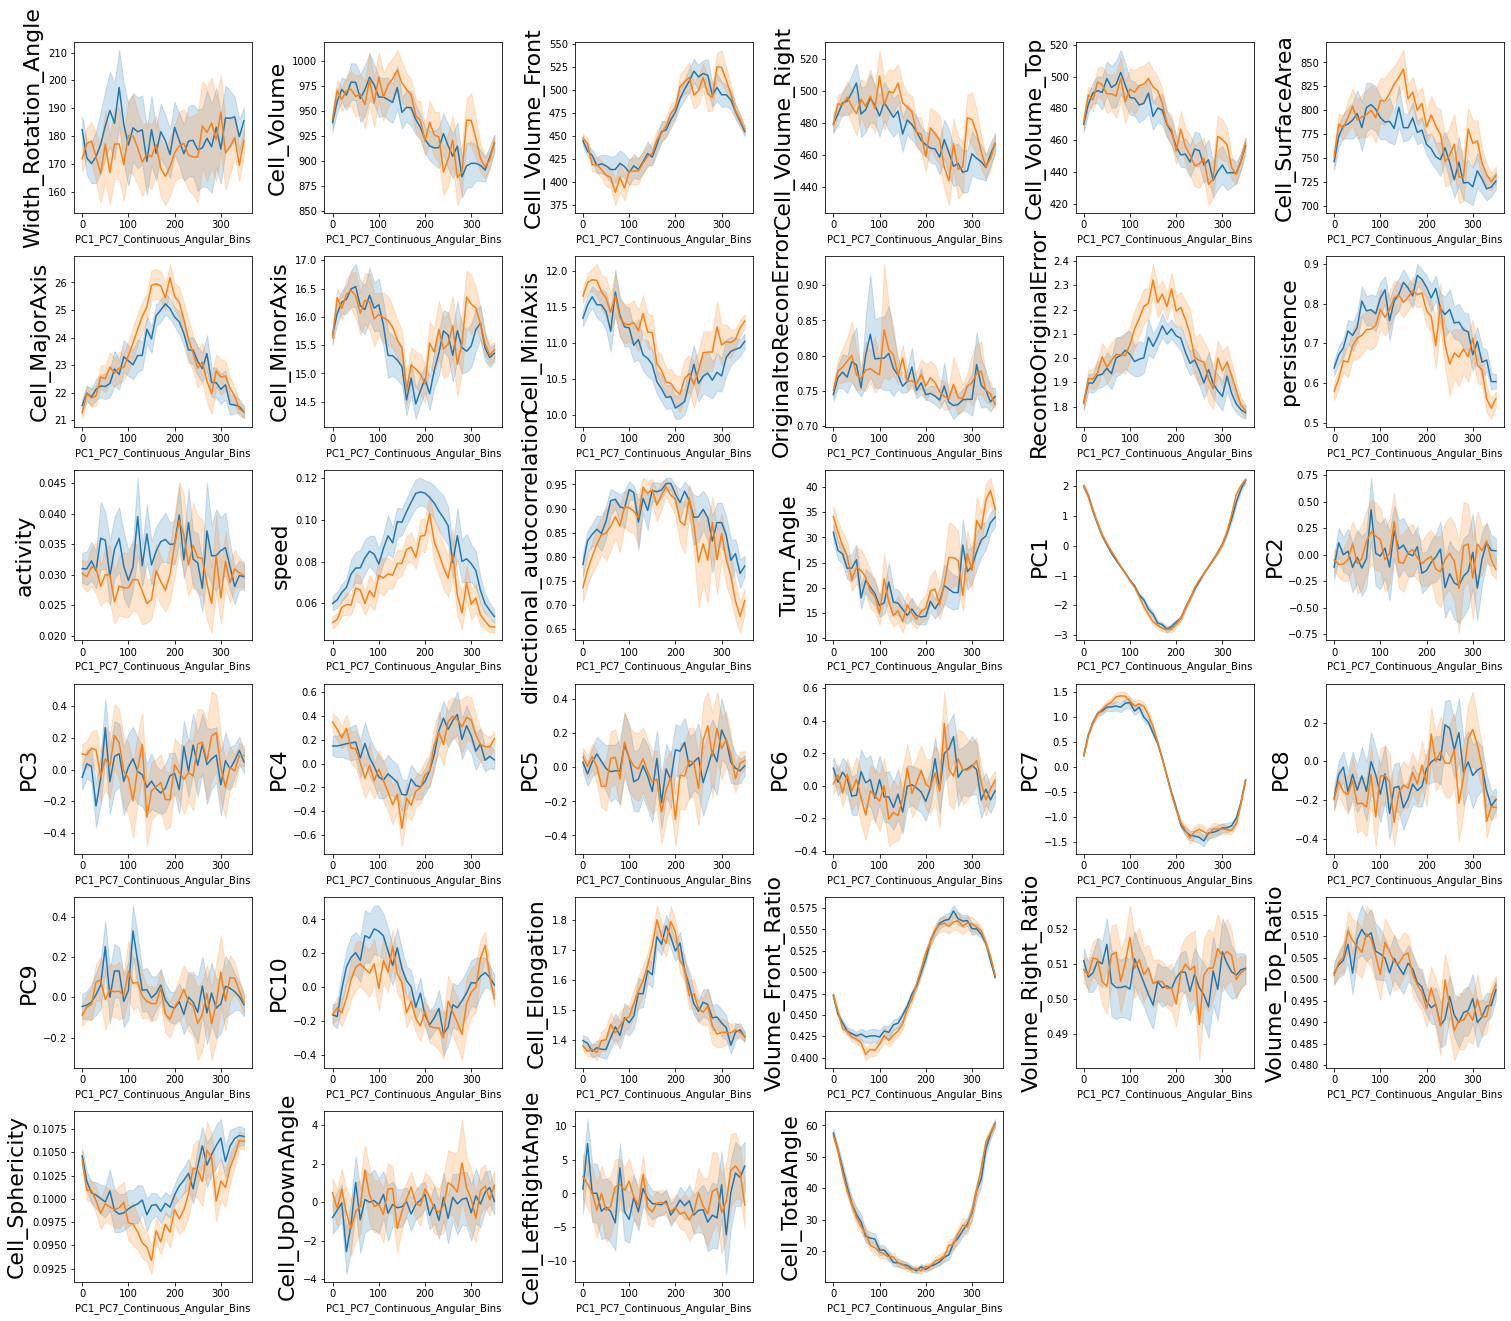

In [5]:


################# LOOK STATS AROUND 1D CYCLE ######################
removeex = []
removeex.extend([x for x in allavgsframe.columns if 'Euler' in x])
removeex.extend([x for x in allavgsframe.columns if 'avg' in x])
removeex.extend([x for x in allavgsframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in allavgsframe.columns if 'intensity' in x])
removeex.extend([x for x in allavgsframe.columns if 'Velocity' in x])
removeex.extend([x for x in allavgsframe.columns if 'Coord' in x])
removeex.extend([x for x in allavgsframe.columns if 'Centroid' in x])
removeex.extend([x for x in allavgsframe.columns if 'Trajectory' in x])
removeex.extend([x for x in allavgsframe.columns if 'Vec' in x])
removeex.extend([x for x in allavgsframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date','bsiter'])
newframe = allavgsframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, hue = 'Treatment', ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs with bootstrapping.png', bbox_inches='tight')